# **<font color='crimson'>«Создание Docker-образа на основе актуальной версии Docker-образа Ubuntu и собственного Dockerfile с загрузкой в репозиторий на Docker Hub»</font>**

---

**Выполнил**: Юмаев Егор

---

## <font color='green'>**Постановка задачи**</font>

---

**Цель**: создание собственного Docker-образа с последующей загрузкой в облачный репозиторий на Docker Hub.

Для достижения цели были поставлены и решены следующие **задачи**:

– Создан кастомный Docker-образ на основе последней (latest) версии Ubuntu c Docker Hub и собственного Dockerfile.

– При создании Docker-образа с помощью bash-скрипта собраны сведения об операционной системе в контейнере.

– С помощью Volume при поднятии Docker-контейнера отчет со сведениями об операционной системе сохранен на локальную машину.

– Кастомный Docker-образ загружен в репозиторий на Docker Hub.

Для поднятия Docker-контейнера в качестве локальной использована виртуальная машина с операционной системой Astra Linux, развернутой в программном продукте для виртуализации операционных систем VirtualBox.

## <font color='green'>**Создание кастомного Docker-образа с загрузкой в облачный репозиторий Docker Hub**</font>

---

Прежде чем скачать с сайта Docker Hub образ Ubuntu самой последней на момент скачивания версии подготовим bash-скрипт для автоматизации сбора сведений об операционной системе.

Создаем bash-скрипт.


In [ ]:
```bash
vim collect_os_info.sh

#!/bin/bash

# каждую позицию собираемых сведений сохраним в отдельную переменную
LINUX_DISTR=$(cat /etc/os-release | grep PRETTY_NAME)
CORES_NUMBER=$(nproc)
RAM=$(cat /proc/meminfo | grep MemTotal)
FREE_DISK_SPACE=$(df -hT /)
FREE_INODES=$(df -hT / -i)
IP_ADDRESS=$(hostname -i)

# записываем собранную информацию в файл report.txt
echo "Общие сведения об операционной системе" > report.txt
echo "" >> report.txt
echo "Сведения о дистрибутиве: " >> report.txt
echo $LINUX_DISTR >> report.txt
echo "" >> report.txt
echo "Сведения о количестве ядер процессора: " >> report.txt
echo $CORES_NUMBER >> report.txt
echo "" >> report.txt
echo "Сведения об объеме оперативной памяти: " >> report.txt
echo $RAM >> report.txt
echo "" >> report.txt
echo "Объем свободного дискового простраства:" >> report.txt
echo $FREE_DISK_SPACE >> report.txt
echo "" >> report.txt
echo "Количество свободных inodes:" >> report.txt
echo $FREE_INODES >> report.txt
echo "" >> report.txt
echo "Сведения об IP-адресе:" >> report.txt
echo $IP_ADDRESS >> report.txt
echo "" >> report.txt
```

Устанавливаем **Docker** для работы в привилегированном режиме.

In [ ]:
```bash
sudo apt install docker.io -y
```

После установки **Docker** предоставим администратору право работать с контейнерами не используя sudo. Для этого пользователя включаем в группу **docker**. Аналогично в группу **docker** следует включить других пользователей, которые будут работать с **docker**.

In [ ]:
```bash
sudo usermod -aG docker $USER
```

Проверяем, что пользователь **sa** включен в группу **docker** и перезапускаем пользовательскую сессию.

In [ ]:
```bash
id sa
exec su - $USER
```

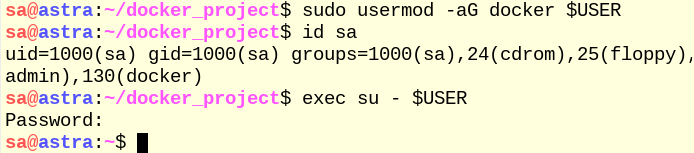

С сайта **Docker Hub** скачаем самую последнюю версию образа операционной системы **Ubuntu**.

In [ ]:
```bash
docker pull ubuntu:latest
```

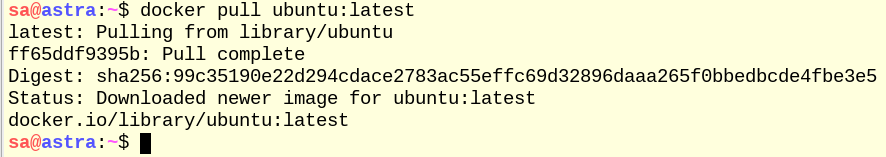

Проверяем, что образ был успешно скачан.

In [ ]:
```bash
docker images
docker system df
```

В папке с проектом, где предварительно был создан bash-скрипт для сбора сведений об операционной системе, создаем **Dockerfile**.

In [ ]:
```bash
vim Dockerfile

FROM ubuntu:latest

# создаем папку для назначения ее рабочей директорией контейнера
RUN mkdir -p /home/sa

# задаем рабочую директорию в контейнере
WORKDIR /home/sa

# копируем из локальной машины в контейнер скрипт
# для сбора сведений об операционной системе
COPY ./collect_os_info.sh ./collect_os_info.sh

# запускаем bash-скрипт, получаем по итогам его работы
# файл со сведениями об операционной системе
RUN /home/sa/collect_os_info.sh
```

С помощью инструмента **Volume** необходимо обеспечить сохранение сведений об операционной системе из контейнера на локальную машину. Для этого необходимо создать **volume**, который указывается при запуске созданного образа.

In [ ]:
```bash
sudo docker volume create os_info_db
```

Проверим список доступных **volume**.

In [ ]:
```bash
docker volume ls
```

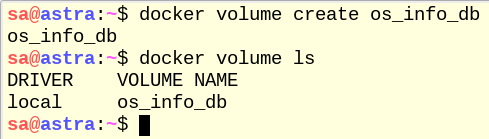

Создаем docker-образ с помощью Dockerfile.

In [ ]:
```bash
docker build -t ubuntu_image:1 .
```

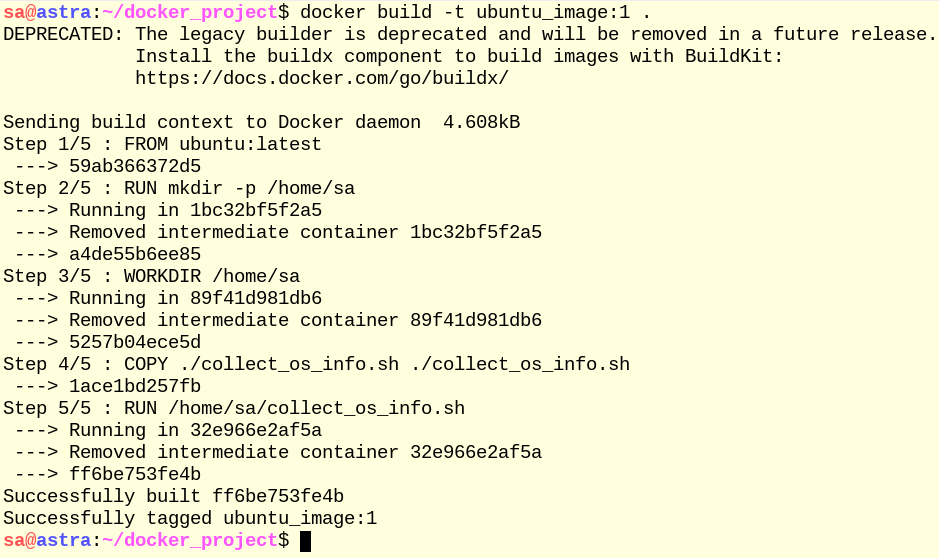

Поднимем контейнер из образа ubuntu_image:1 с указанием volume **os_info_db**.

In [ ]:
```bash
docker run --name ubuntu_image -v os_info_db:/home/sa/ ubuntu_image:1
```

Выведем список работающих контейнеров и всех поднятых контейнеров.

In [ ]:
```bash
docker ps
docker ps -a
```

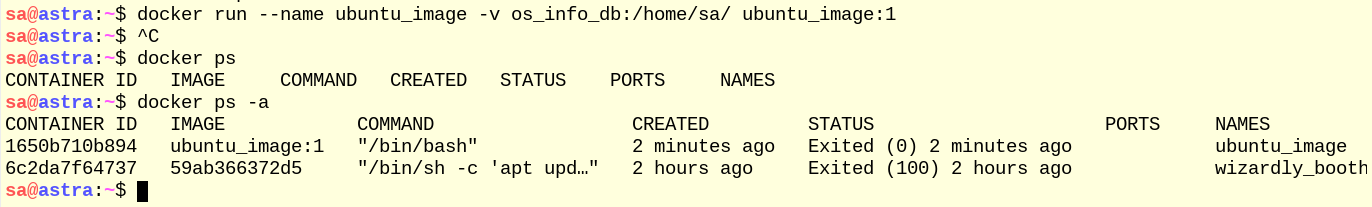

Выведем путь до директории на локальной машине, где хранится созданный **volume os_info_db**.

In [ ]:
```bash
docker volume inspect os_info_db
```

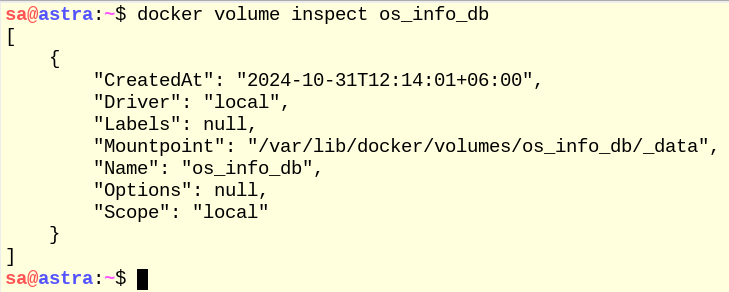

Посмотрим, какие файлы появились в созданном **volume** после поднятия контейнера.

In [ ]:
```bash
sudo ls /var/lib/docker/volumes/os_info_db/_data
```

Видим, что на локальную машину в созданный **volume** были скопированы bash-скрипт **collect_os_info.sh** и сведения об операционной системе, поднятой в контейнере, – **report.txt**. Выведем содержимое отчета.

In [ ]:
```bash
sudo cat /var/lib/docker/volumes/os_info_db/_data/report.txt
```

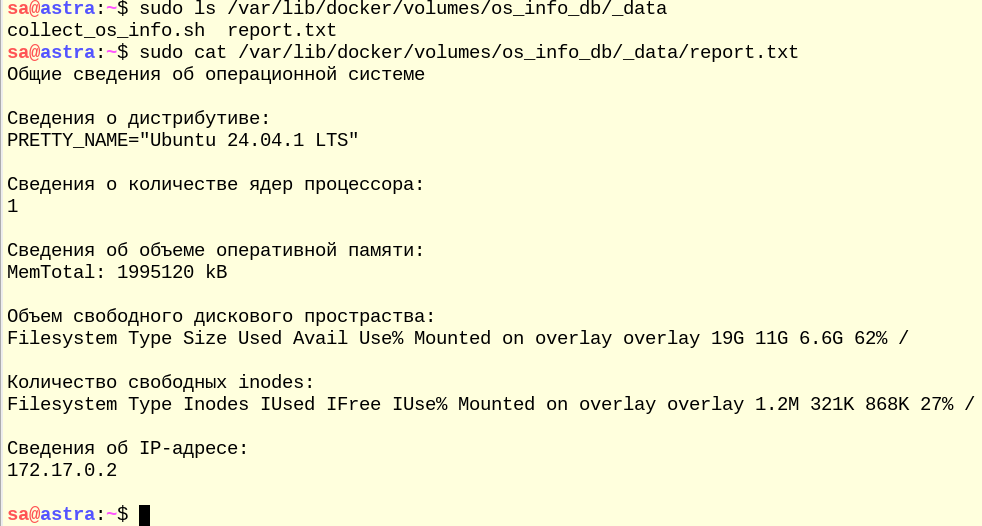

Остановим и удалим поднятый контейнер.

In [ ]:
```bash
docker stop ubuntu_image
docker rm $(docker ps -qa)
```

Проверим, сохранился ли bash-скрипт и отчет об основных характеристиках операционной системы на локальной машине.

In [ ]:
```bash
sudo ls /var/lib/docker/volumes/os_info_db/_data
sudo cat /var/lib/docker/volumes/os_info_db/_data/report.txt
```

Файлы остались на месте, имеется возможность посмотреть отчет.


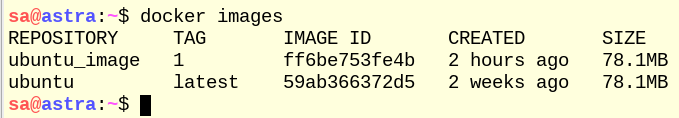


Осталось загрузить созданный образ **ubuntu_image:1** в репозиторий на **Docker Hub**.


Проходим авторизацию на портале Docker Hub.

In [ ]:
```bash
docker login
```

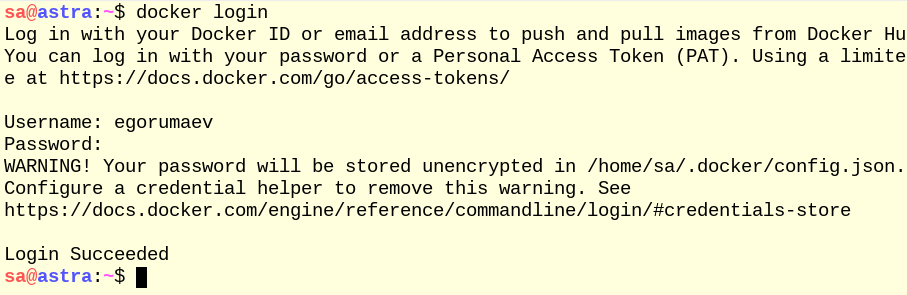

Для загружаемого образа сменим название и тэг для полного соответствия названию репозитория на Docker Hub.

In [ ]:
```bash
docker tag ubuntu_image:1 egorumaev/store_project_ubuntu:latest
```

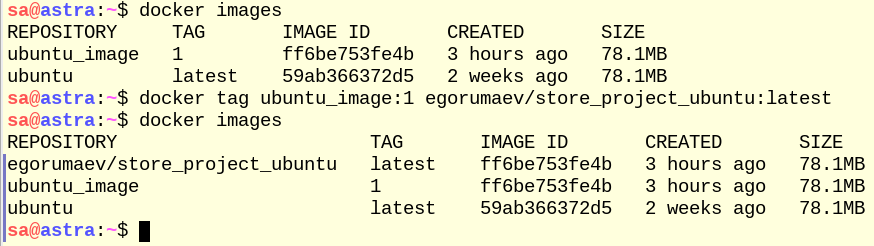

Загрузим созданный образ в репозиторий.

In [ ]:
```bash
docker push egorumaev/store_project_ubuntu:latest
```

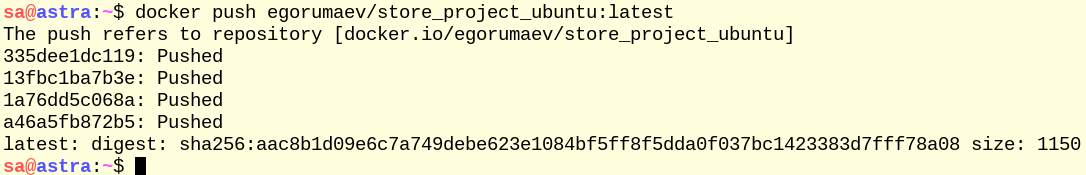

Проверим, появился ли образ на портале Docker Hub.

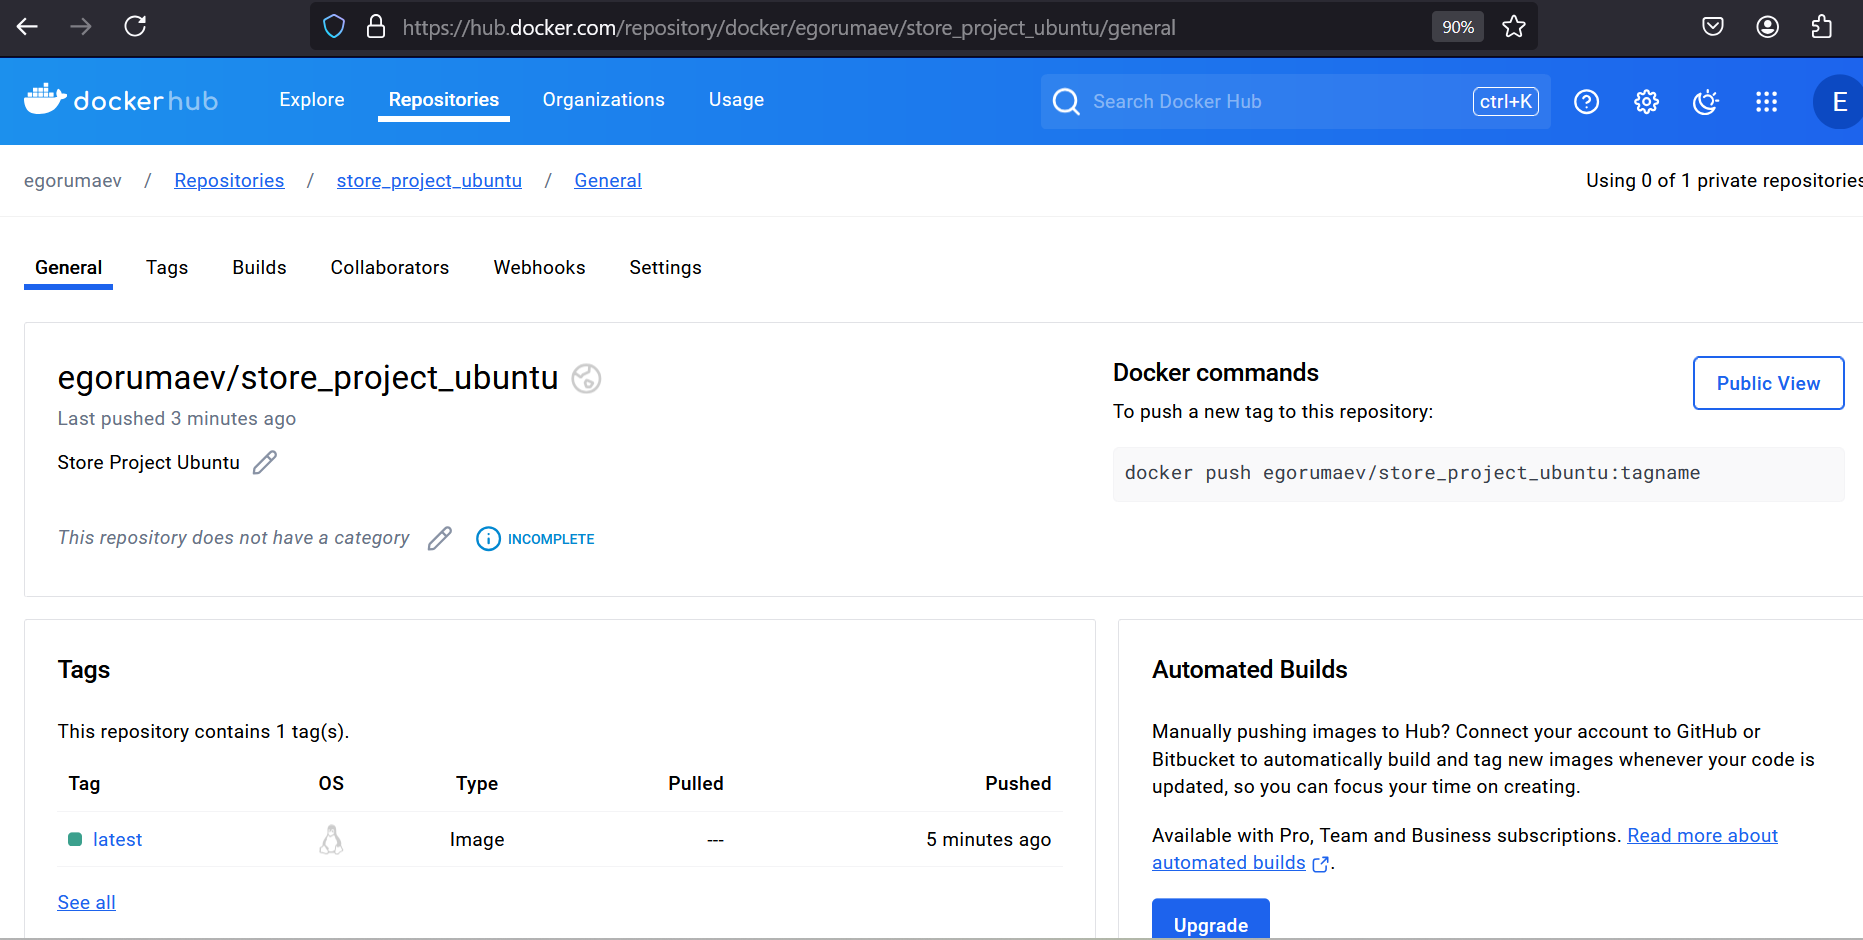

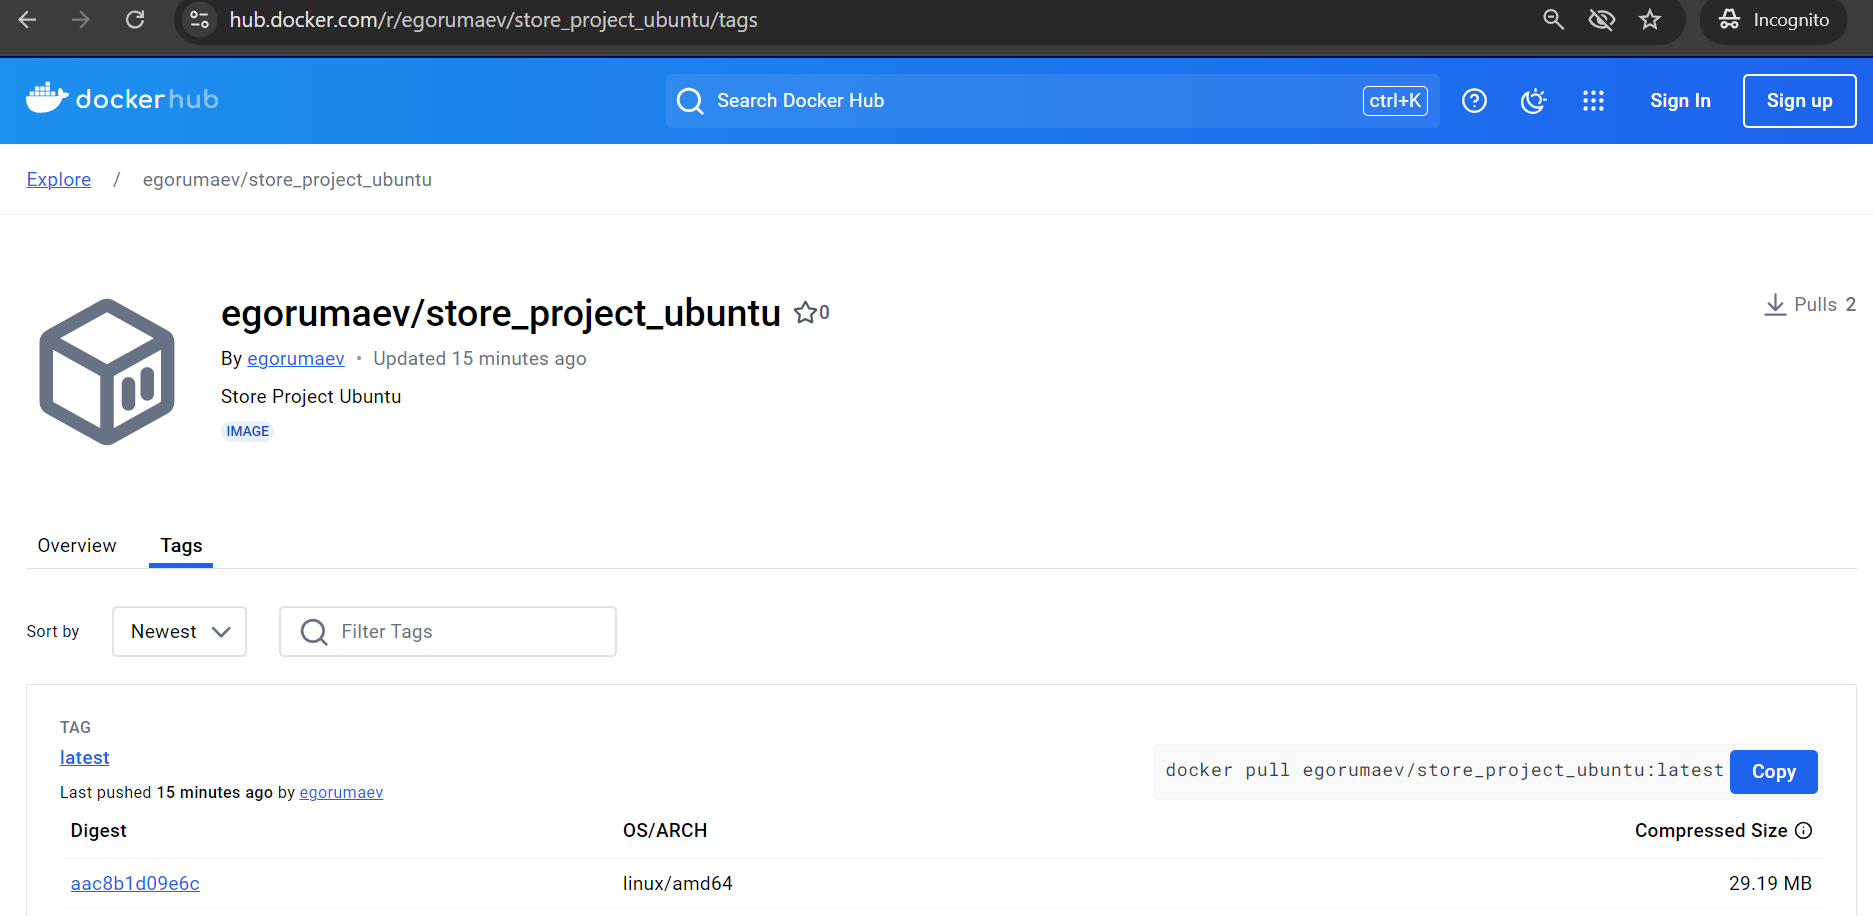

На локальной машине закроем соединение с облачным хранилищем Docker Hub.

In [ ]:
```bash
docker logout
```

Созданный образ **egorumaev/store_project_ubuntu:latest** успешно загружен в облачное хранилище **Docker Hub** и может быть скачен с помощью следующей команды:

In [ ]:
```bash
docker pull egorumaev/store_project_ubuntu:latest
```

## <font color='mediumblue'>**Результаты**</font>

---

* Подготовлен bash-скрипт для сбора сведений об операционной системе Ubuntu.

* Создан Volume для получения на локальную машину из Docker-контейнера отчета со сведениями об операционной системе.

* В Docker-контейнере развернута операционная система Ubuntu 24.04.1 с количеством ядер процессора 1, объемом оперативной памяти 1.9Gb, количеством свободного дискового пространства 11Gb из 19Gb, количеством свободных inodes 0.321M из 1.2M.

* Название созданного Docker-образа приведено в соответствие названию репозитория на Docker Hub.

* Собственный Docker-образ загружен в реопзиторий на Docker Hub и доступен для скачивания на локальные машины по команде **docker pull egorumaev/store_project_ubuntu:latest**.